# Analyse des clusters obtenus par la méthode de clustering spectral

In [1]:
!pip install demoji

In [2]:
!pip install wordcloud

In [53]:
!pip install spacy

In [36]:
import json
import pandas as pd
import string
import demoji
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load('fr_core_news_md')
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop


from wordcloud import WordCloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Première étape : on crée un dataframe contenant les tweets.

In [13]:
df = pd.read_json("tweets.json", dtype = False)
df.head(10)

author_id                created_at edit_history_tweet_ids  \
0            523849904 2022-12-13 21:14:43+00:00  [1602774039013240833]   
1  1546342369385226242 2022-12-13 21:14:33+00:00  [1602773998110216192]   
2  1600649374022995968 2022-12-13 21:14:32+00:00  [1602773991353090050]   
3            491271694 2022-12-13 21:14:27+00:00  [1602773973141446656]   
4  1088810623465590784 2022-12-13 21:14:27+00:00  [1602773970817785856]   
5           1379055842 2022-12-13 21:14:24+00:00  [1602773960424407041]   
6   962673658119557121 2022-12-13 21:14:20+00:00  [1602773943848505345]   
7  1570515228768587776 2022-12-13 21:14:19+00:00  [1602773937985040384]   
8            629486394 2022-12-13 21:14:15+00:00  [1602773922746978306]   
9           1536397663 2022-12-13 21:14:14+00:00  [1602773915113328644]   

                    id                                               text  
0  1602774039013240833  Mon mari est en dépression parce qu’on ne verr...  
1  1602773998110216192                                BIEN MESSI. #ARGCRO  
2  1602773991353090050  Les @ qui disent que Messi était invisible con...  
3  1602773973141446656             Messi c’est vraiment un joueur #ARGCRO  
4  1602773970817785856                              Messi magic 🪄 #ARGCRO  
5  1602773960424407041                                     Motm ? #ARGCRO  
6  1602773943848505345  Bof trop c'est trop, Kiki, tu es en mission ⚔️...  
7  1602773937985040384  Boateng peut enfin être soulagé, un héritier a...  
8  1602773922746978306  #FIFAWorldCup L'Argentine, premier pays qualif...  
9  1602773915113328644  Avec un Messi des grands jours victoire amplem...

Deuxième étape : créer une variable qui contient le numéro de cluster de chaque utilisateur.
On crée d'abord un dictionnaire dont les clés sont les ids des utilisateurs et les valeurs sont les numéros de cluster.

In [14]:
#On récupère les labels
values = np.loadtxt("labels_spectral.txt")

#On récupère le dictionnaire des utilisateurs
with open('dictionnaire_following-v2.json', 'r') as fp:
    dictionnaire = json.load(fp)
keys = dictionnaire.keys()

# pour l'instant, un dictionnaire où chaque clé renvoie à None
clusters = dictionnaire.fromkeys(keys)

for i,key in enumerate(list(keys)) :
    clusters[key] = int(values[i])
    
num_cluster = []
for id in df['author_id']:
    num_cluster.append(clusters.get(str(id)))

df['id_cluster'] = num_cluster

87

Nous allons analyser le vocabulaire utilisé dans les tweets de chaque cluster.
Avant toute chose, il est nécessaire de nettoyer les tweets, c'est-à-dire de supprimer la ponctuation, les majuscules, les caractères spéciaux, les emojis, etc.
On va également créer une liste de stopwords à supprimer.

In [72]:
#rajouter les mots qui apparaissent très souvent et qui ne sont pas utiles pour l'analyse

stop_words_context = ["fifaworldcup", "argcro", "a", "argentinavscroatia"]
stop_words = list(fr_stop) + stop_words_context
print(stop_words)

def rm_stopwords(text):
    return [w for w in text.split() if w not in stop_words]

['ho', 'préalable', 'en', 'neuvième', 'quatre-vingt', 'excepté', 'restant', 'miennes', 'voilà', 'tes', 'troisième', 'sur', 'souvent', 'ouverts', 'semble', 'lesquels', 'telle', 'quelques', 'entre', 'seize', 'huit', 'avait', 'plutôt', 'dont', 'allaient', 'celui-là', 'diverses', 'tienne', 'vous-mêmes', 'celle-la', 'pour', 'bas', 'voici', 'diverse', 'parmi', 'voila', 'dix-huit', 'ta', 'déjà', 'houp', 'apres', 'aie', 'devers', 'via', 'l’', 'juste', 'abord', 'onzième', 'dejà', 'autres', 'nôtre', 'quiconque', 'six', 'specifiques', 'sien', 'etc', 'une', 'nous-mêmes', 'nouveau', 'pourquoi', 'toutes', 'i', 'cinquième', 'importe', 'longtemps', 'moi', 'moi-même', 'toujours', 'la', 'pourrait', 'auront', 'autrement', 'soi-même', 'quatre', 'deuxièmement', 'pres', 'mien', 'étaient', 'eux-mêmes', 'sienne', 'tien', 'retour', "d'", 'lui', 'celle-là', "t'", 'hormis', 'anterieures', 'fait', 'si', 'specifique', 'nous', 'semblaient', 'avoir', 'mon', 'tellement', 'ait', 'tiens', 'trente', 'dit', 'peut', 'afin


La fonction suivante prend en argument un texte et renvoie le texte nettoyé.

In [66]:
def clean(text):
    #tout mettre en minuscules
    text = text.lower()
    #suppression de la ponctuation
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    #suppression des chiffres (pour une analyse de vocabulaire, ils ne sont pas nécessaires)
    text = ''.join([i for i in text if not i.isdigit()])
    #suppression des emojis
    for item in demoji.findall(text):
        text = text.replace(item,"")
    #suppression des mentions
    text = re.sub("@[A-Za-z0-9_]+","", text)
    #suppression des hashtags
    text = re.sub("#[A-Za-z0-9_]+","", text)
    #suppression des liens 
    #retirer les liens
    text = re.sub(r"\S*https?:\S*", "", text)
    return text

On a également besoin de lemmatiser le texte.

In [60]:
def text_lemmatize(text):
    nlp_text = nlp(text)
    dict_lemm = {token : token.lemma_ for token in nlp_text}
    words = []
    for x in nlp_text : 
        if len(x) >= 0 :
            words.append(dict_lemm[x])
    return ' '.join(words)

On va ensuite créer un wordcloud pour chaque cluster.
Première étape : dans le dataframe des tweets, créer une nouvelle variable "clean text" qui contient le texte des tweets modifiés grâce à la fonction clean.

In [67]:
df["clean_text"] = df["text"].apply(lambda x: clean(x))

In [68]:
df["tweet_lemma"] = df["clean_text"].apply(lambda x: text_lemmatize(x))

In [44]:
df.head(5)

author_id                created_at edit_history_tweet_ids  \
0            523849904 2022-12-13 21:14:43+00:00  [1602774039013240833]   
1  1546342369385226242 2022-12-13 21:14:33+00:00  [1602773998110216192]   
2  1600649374022995968 2022-12-13 21:14:32+00:00  [1602773991353090050]   
3            491271694 2022-12-13 21:14:27+00:00  [1602773973141446656]   
4  1088810623465590784 2022-12-13 21:14:27+00:00  [1602773970817785856]   

                    id                                               text  \
0  1602774039013240833  Mon mari est en dépression parce qu’on ne verr...   
1  1602773998110216192                                BIEN MESSI. #ARGCRO   
2  1602773991353090050  Les @ qui disent que Messi était invisible con...   
3  1602773973141446656             Messi c’est vraiment un joueur #ARGCRO   
4  1602773970817785856                              Messi magic 🪄 #ARGCRO   

   id_cluster                                         clean_text  \
0         0.0  mon mari est en dépression parce qu’on ne verr...   
1         1.0                                bien messi   argcro   
2         0.0  les   qui disent que messi était invisible con...   
3         1.0             messi c’est vraiment un joueur  argcro   
4         0.0                               messi magic   argcro   

                                         tweet_lemma  
0  mon mari être dépression parce qu’ voir plus m...  
1                                  bien messi argcro  
2  le qui dire que messi être invisible contre cr...  
3                  messi être vraiment joueur argcro  
4                                 messi magic argcro

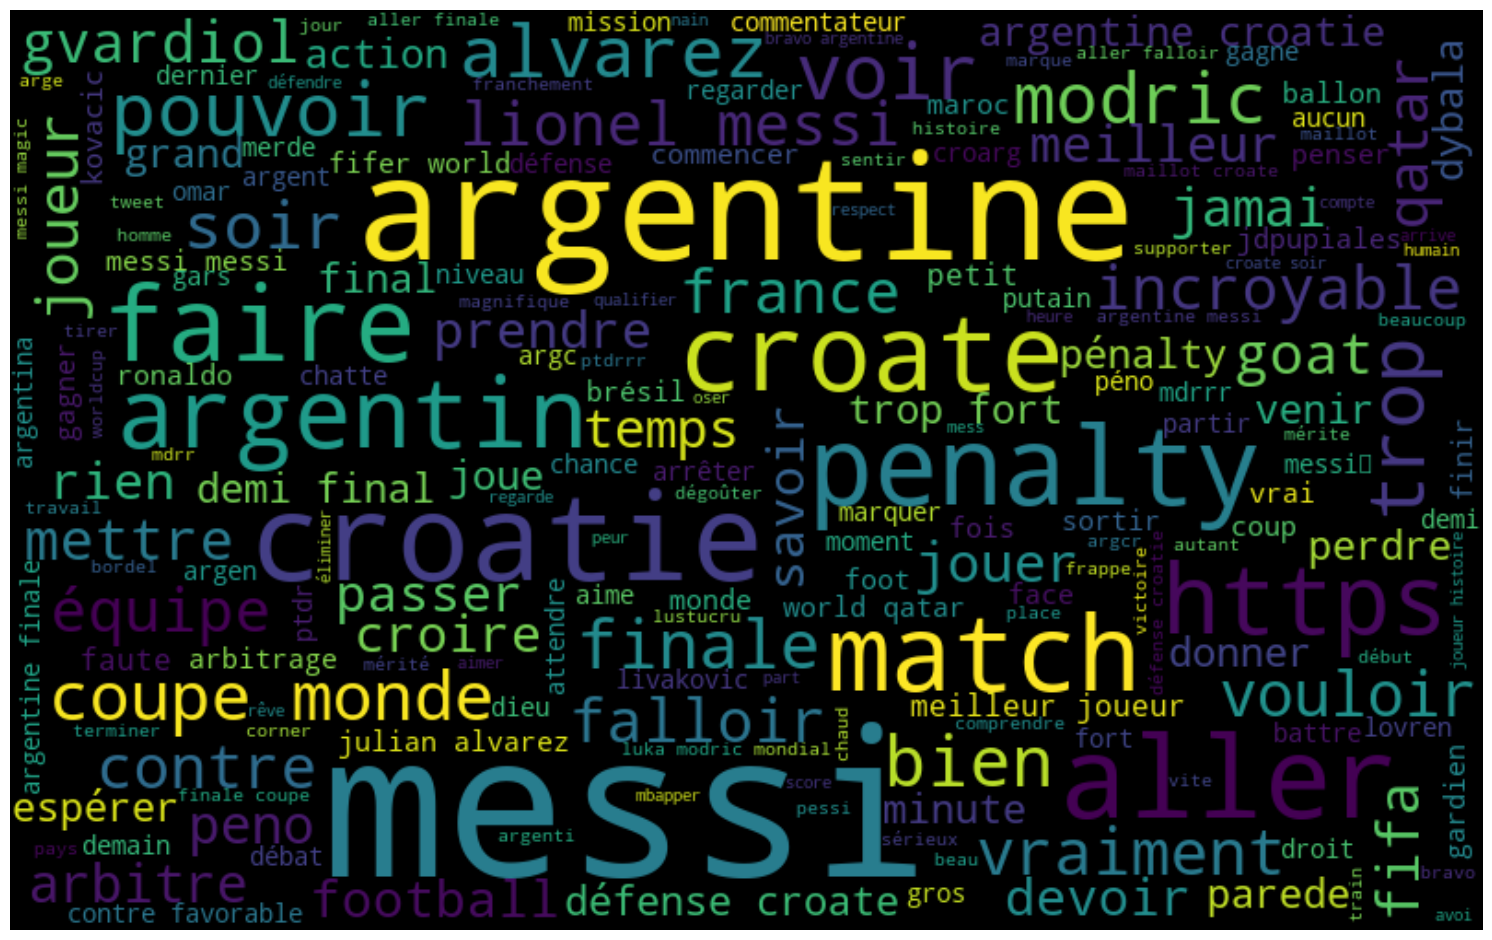

In [69]:
wordcloud = WordCloud(stopwords=stop_words, width=800, height=500,
                      random_state=21, max_font_size=110, min_word_length=4).generate(df["tweet_lemma"].to_string())
plt.figure(figsize=(19, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [70]:
def wordcloud_cluster(cluster) :
    df_cloud = df[df['id_cluster'] == cluster]
    wordcloud = WordCloud(stopwords=stop_words, width=800, height=500,
                      random_state=21, max_font_size=110, min_word_length=3).generate(df_cloud["tweet_lemma"].to_string())
    plt.figure(figsize=(19, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off');

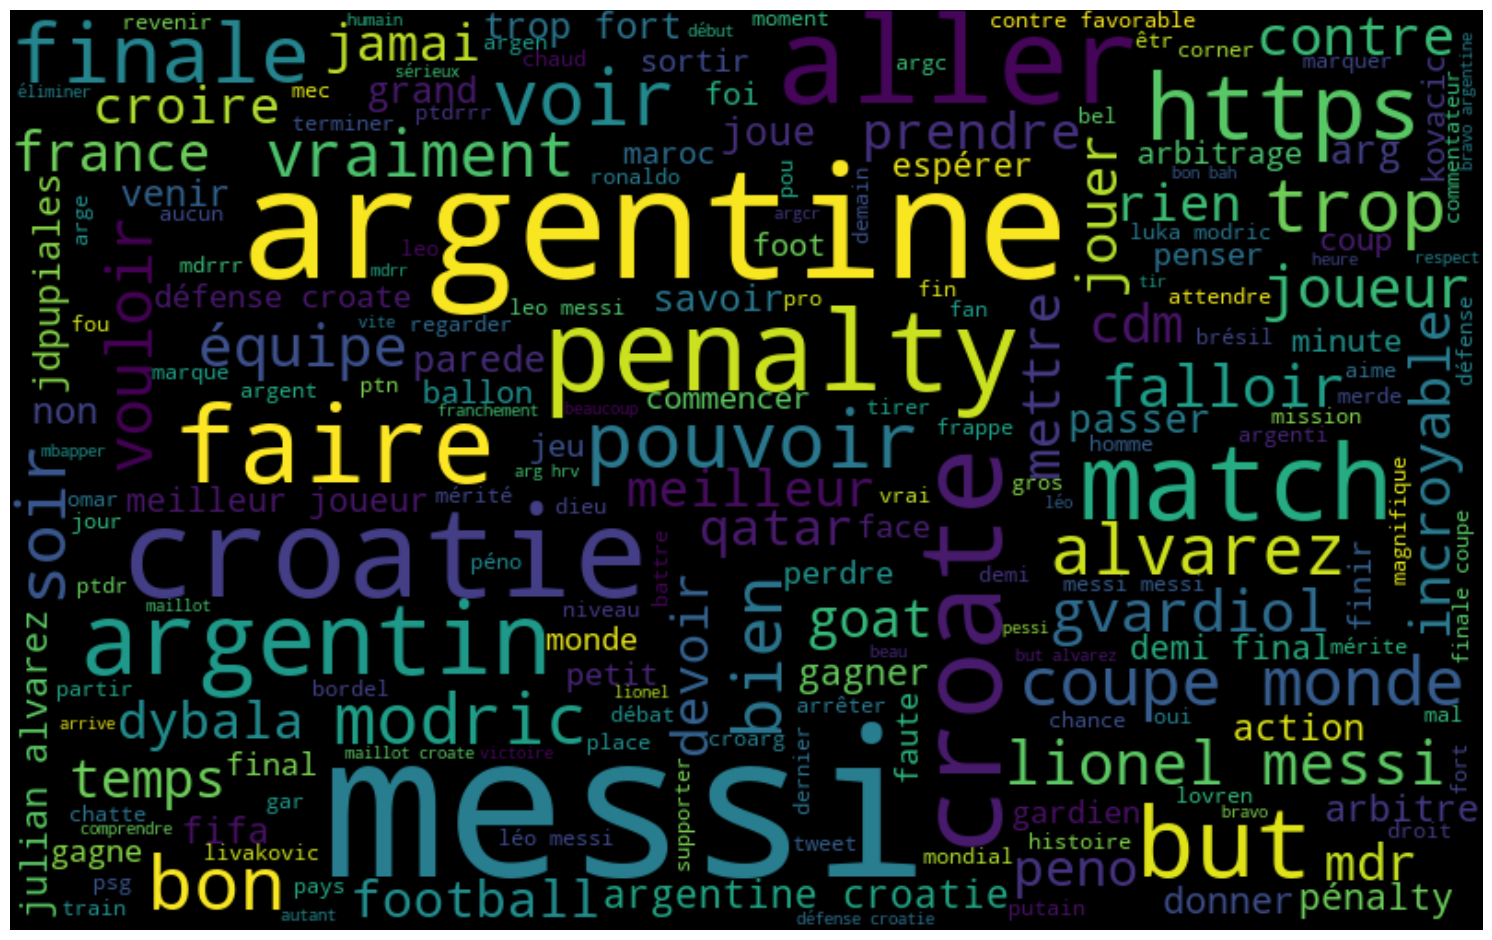

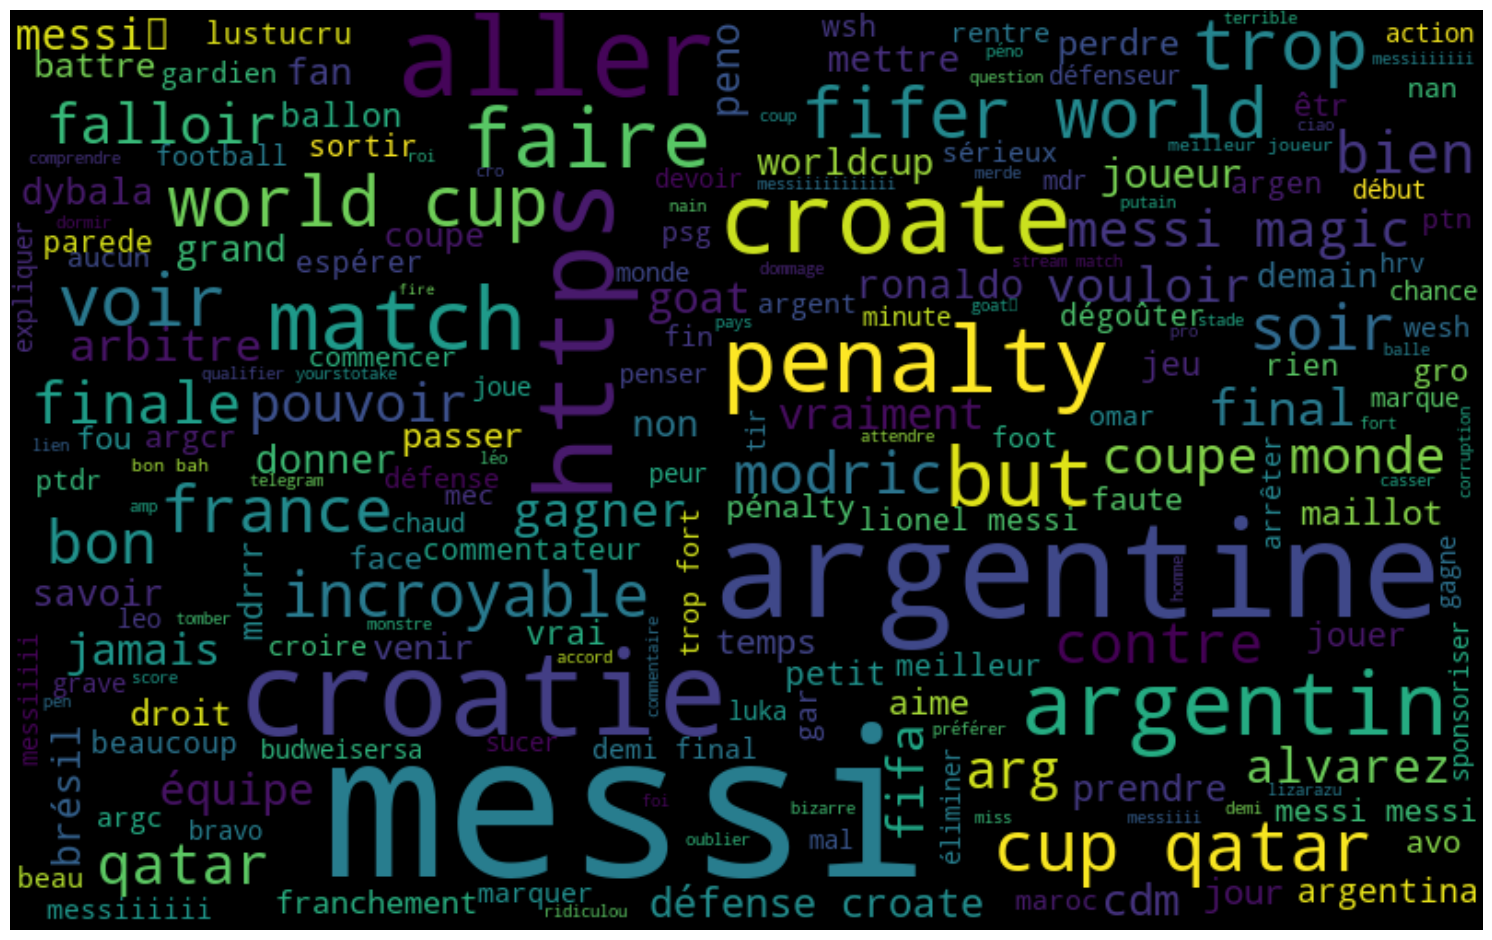

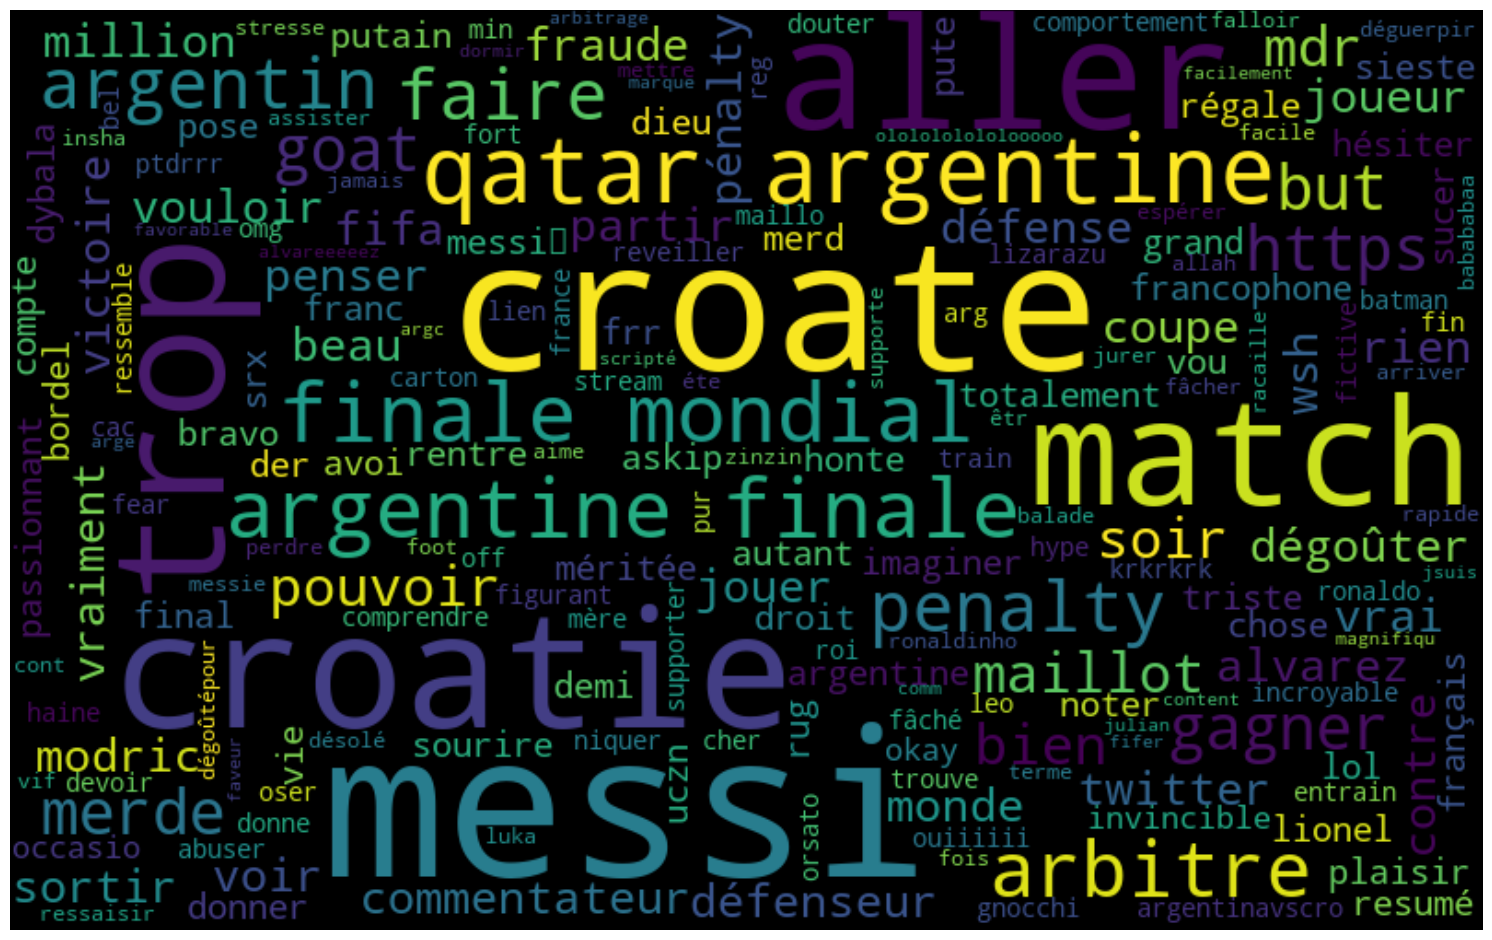

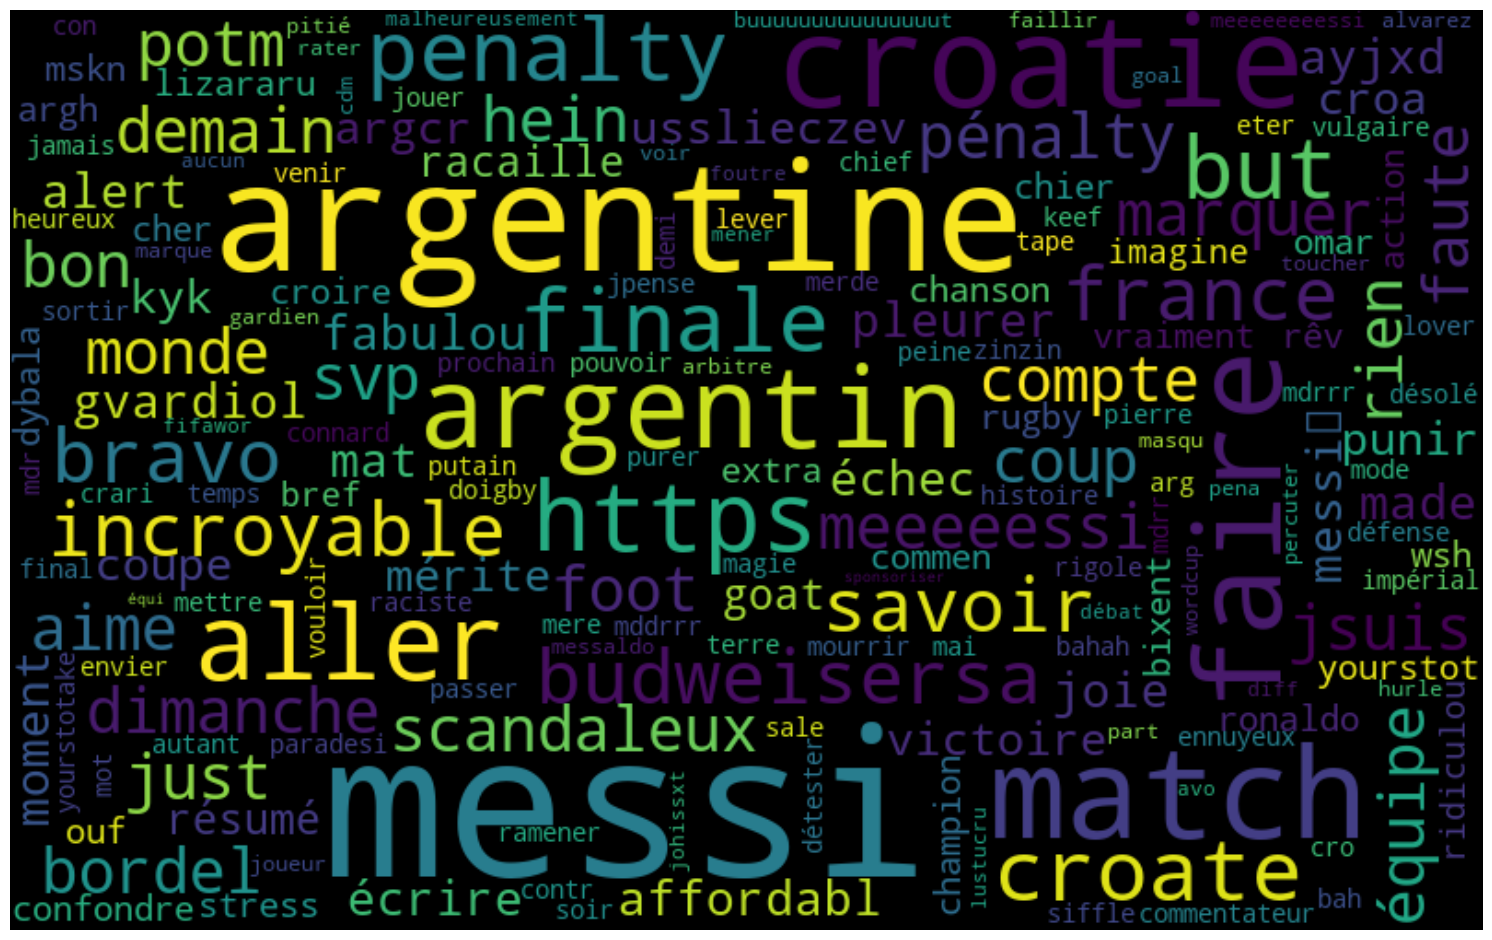

In [71]:
list_clusters = np.unique(values)
for cluster in list_clusters:
    wordcloud_cluster(cluster)

On va maintenant créer différentes variables concernant les tweets, de manière à analyser d'autres caractéristiques que le vocabulaire.
Pour notre analyse, il peut être utile de connaître le nombre de hashtags dans chaque tweet, le nombre de majuscules ainsi que le nombre de points d'exclamation.
Le dataframe initial contient déjà le nombre de likes et de retweets.

In [17]:
def count_hashtags(text):
    find = re.compile("([#]\w+)").findall(text)
    return len(find)

df["nb_hashtags"] = df["text"].apply(lambda x : count_hashtags(x))

def count_exclamation(text):
    find = re.compile("(\w?\s?[!])").findall(text)
    return len(find)

df["nb_exclamation"] = df["text"].apply(lambda x : count_exclamation(x))

def count_maj(text):
    find = re.compile("([A-Z][A-Z]+)").findall(text)
    return len(find)

df["nb_maj"] = df["text"].apply(lambda x : count_maj(x))

Statistiques descriptives sur les variables, par cluster.

In [18]:
round(df.describe(), 3)

author_id            id  nb_hashtags  nb_exclamation    nb_maj
count  9.054000e+03  9.054000e+03     9054.000        9054.000  9054.000
mean   6.905736e+17  1.602758e+18        1.547           0.305     1.997
std    6.471105e+17  8.875457e+12        1.193           1.043     2.296
min    6.530300e+04  1.602736e+18        1.000           0.000     0.000
25%    1.050174e+09  1.602750e+18        1.000           0.000     1.000
50%    8.415568e+17  1.602760e+18        1.000           0.000     1.000
75%    1.306720e+18  1.602764e+18        2.000           0.000     2.000
max    1.602762e+18  1.602774e+18       18.000          22.000    38.000

Il faut ajouter une variable "cluster" dans le dataframe, qui contient l'identifiant du cluster auquel appartient chaque utilisateur.